In [1]:
from convolutional_coding import Convolution
from jepg import compress,decompress
from awgn import add_awgn_noise
from crc32 import crc32,verify_crc32
from hexString_to_bitList import get_bitList_from_hexString,get_hexString_from_bitList
import matplotlib.pyplot as plt
import cv2
import base64
import math
PATH='./images/image.bmp'



In [2]:
# 原始图像路径,灰度图像
img_path = './images/image.bmp'
# 读取原始图像,cv2.imread()默认是用color模式读取的，保持原样读取要加上第二个参数-1,即CV_LOAD_IMAGE_GRAYSCALE
# 得到图像原数据流
img_data = cv2.imread(img_path, -1)
cv2.imwrite('./images/jpeg_decompress.jpg', img_data)
img0 = cv2.imread('./images/jpeg_decompress.jpg', -1)

In [3]:
# 得到压缩后图像数据
img_compress = compress(img_data, 50)
# 得到解压缩后图像数据的二进制列表形式
img_compress=get_bitList_from_hexString(img_compress)

In [9]:
# 将待发送的文件分割成多个数据包，每个数据包的大小为1024字节，分别对每一个数据包先进行crc32编码，再进行卷积编码，然后添加到发送队列中
packet_size = 64
# 实例化一个(2,1,k)卷积编码器，2<=k<=8
conv = Convolution(4)

In [10]:
send_data=[]#发送队列
send_data_length=math.ceil(len(img_compress)/8/packet_size)#发送队列长度
for i in range(send_data_length-1):
    send_bag=img_compress[i*packet_size*8:(i+1)*packet_size*8]#取出一个待发送队列的数据包
    send_bag_crc32=crc32(send_bag)#对待发送的数据包进行crc32编码
    send_bag_crc32_conv=conv.encode_conv(send_bag_crc32)#对crc32编码后的数据包进行卷积编码
    send_data.append(send_bag_crc32_conv)#将编码后的数据包添加到发送队列中
send_bag=img_compress[(send_data_length-1)*packet_size*8:]#取出最后一个待发送的数据包
send_bag_crc32=crc32(send_bag)#对待发送的数据包进行crc32编码
send_bag_crc32_conv=conv.encode_conv(send_bag_crc32)#对crc32编码后的数据包进行卷积编码
send_data.append(send_bag_crc32_conv)#将编码后的数据包添加到发送队列中

In [12]:
#模拟发送端发送数据包、信道传输、接收端viterbi译码、crc校验、数据包错误重传
recv_data=[]#接收到的数据
failure_count=0#数据包错误重传次数
for i in range(send_data_length):
    num=0
    send_bag=send_data[i]#取出一个待发送的数据包
    while True:
        #对数据包加入高斯白噪声，模拟awgn信道传输
        recv_bag=add_awgn_noise(send_bag,7)
        #对接收到的数据包进行viterbi译码
        recv_bag=conv.decode_conv(recv_bag)
        #对接收到的数据包进行crc32校验
        if verify_crc32(recv_bag):
            recv_data.append(recv_bag[:-32])#校验通过,数据包接收成功
            break
        failure_count+=1
        num+=1
    # print('第',i,'个包传输失败次数:',num)
print('数据包传输失败次数:',failure_count)

数据包传输失败次数: 6599


In [13]:
# 将接收到的数据包合并成一个数据流
temp = []
for i in range(len(recv_data)):
    temp.extend(recv_data[i])
recv_data = temp
# 将接收到的数据流转换成16进制字符串
recv_data = get_hexString_from_bitList(recv_data)
# 存储压缩后的图像
img_compress_path = './images/img_compress.jpg'
with open(img_compress_path, 'wb') as f:
    f.write(base64.b16decode(recv_data.upper()))

In [14]:
# jpeg解压缩
img_decompress = decompress(img_compress_path)

In [15]:
# 读取发送端压缩后的图像
img1 = cv2.imread('./images/img_compress.jpg', -1)


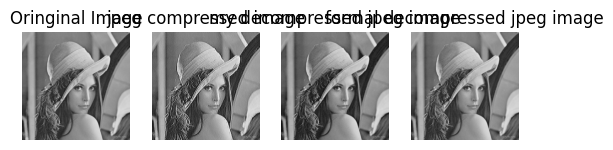

In [16]:

# 结果展示
# 子图1，原始图像
plt.subplot(141)
# imshow()对图像进行处理，画出图像，show()进行图像显示
plt.imshow(img_data, cmap=plt.cm.gray)
plt.title('Oringinal Image')
# 不显示坐标轴
plt.axis('off')

 # 子图2，自己写的jpeg压缩后解压的图像
plt.subplot(143)
plt.imshow(img_decompress, cmap=plt.cm.gray)
plt.title('my decompressed jpeg image')
plt.axis('off')

 # 子图3，官方jpeg压缩后解码图像
plt.subplot(144)
plt.imshow(img0, cmap=plt.cm.gray)
plt.title('formal decompressed jpeg image')
plt.axis('off')

 # 子图4，jpeg压缩后图像
plt.subplot(142)
plt.imshow(img1, cmap=plt.cm.gray)
plt.title('jpeg compressed image')
plt.axis('off')
plt.show()

